ใน ep นี้ เราจะมาเรียนรู้ งานจำแนกหมวดหมู่ข้อความ Text [Classification](https://www.bualabs.com/archives/tag/classification/) ซึ่งเป็นงานพื้นฐานทางด้าน [NLP](https://www.bualabs.com/archives/tag/nlp/) ด้วยการทำ Latent Semantic Analysis (LSA) วิเคราะห์หาความหมายที่แฝงอยู่ในข้อความ โดยใช้เทคนิค Singular Value Decomposition (SVD) และ Non-negative Matrix Factorization (NMF)

# 1. Import

In [0]:
# ! pip install fbpca

In [0]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

In [0]:
%matplotlib inline
np.set_printoptions(suppress=True)

# 2. Dataset

ในเคสนี้เราจะใช้ Dataset เป็นข้อความจาก Newsgroup 4 หมวดหมู่ คือ 

1. อเทวนิยม
1. ศาสนา 
1. คอมพิวเตอร์กราฟฟิก 
1. วิทยาศาสตร์ อวกาศ 

Newsgroup คือ ชุมชนออนไลน์ เหมือน Webboard ในยุค 80 ก่อนที่ www จะเป็นที่นิยม

In [0]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

ดูตัวอย่างข้อมูล มีจำนวน 2034 Record

In [0]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

ชื่อไฟล์

In [0]:
newsgroups_train.filenames[1200:1203]

array(['/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/37937',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/alt.atheism/51124',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.space/60964'],
      dtype='<U86')

ดูตัวอย่างเนื้อหา 3 ข้อความ

In [0]:
print("\n============================\n".join(newsgroups_train.data[1200:1203]))




I sure did use version 3.2. It works fine with most software but NOT
with Animator Pro and that one is quite important to me. Pretty
useless program without that thing working IMHO.
So I hope the author can fix that.

/Daniel...



 
 
It was no criticism of Islam for a change, it was a criticism of the
arguments used. Namely, whenever people you identify as Muslims are
the victims of the attacks of others, they are used an argument for
the bad situation of Muslims. But whenever deeds by Muslim that victimize
others are named, they do not count as an argument because what these
people did was not done as a true Muslims. No mention is made how Muslims
are the cause of a bad situation of another party.


Hmmmm....  The prefix "peri-" is Greek, not Latin, so it's usually used
with the Greek form of the name of the body being orbited.  (That's why
it's "perihelion" rather than "perisol", "perigee" rather than "periterr",
and "pericynthion" rather than "perilune".)  So for Jupiter I'd ex

รหัส Category ของ 3 ข้อความด้านบน

In [0]:
newsgroups_train.target[1200:1203]

array([1, 0, 2])

3 ข้อความด้านบน อยู่ Category ไหน

In [0]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[1200:1203]]

array(['comp.graphics', 'alt.atheism', 'sci.space'], dtype='<U18')

# 3. Vectorize 

ในการจะหาว่าเอกสารนี้เกี่ยวกับเรื่องอะไร เอกสาร 2 เอกสาร เขียนถึงเรื่องราวในหัวข้อเดียวกัน อยู่หมวดหมู่เดียวกัน วิธีที่ง่ายที่สุด ตรงตัวที่สุด คือการนับจำนวนแต่ละคำที่อยู่ในแต่ละเอกสาร แล้วนำมาเปรียบเทียบกันตรง ๆ โดยยังไม่ต้องสนใจลำดับของคำ

Import Library ในการนับคำศัพท์

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

ดาวน์โหลด โมเดลภาษา ในที่นี้คือภาษาอังกฤษ

In [0]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 3.1 Tokenize and Lemmatize

ประกาศ Class สำหรับทำ Tokenization ข้อความ String ให้เป็น Token พร้อม [Lemmatization](https://www.bualabs.com/archives/2952/what-is-stemming-what-is-lemmatization-different-stemming-lemmatization-nlp-ep-3/) แปลง Token ที่ได้ ให้อยู่ในรูปฟอร์มพื้นฐาน

In [0]:
from nltk import word_tokenize, stem

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = stem.WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

## 3.2 Create Matrix of Token Counts

แปลงรายการข้อความทั้งหมด ให้เป็น Matrix ของ จำนวน Token เรียกว่า Term-Document Matrix

Matrix 1 Row คือ 1 Vector ข้อความ, มีหลาย ๆ Vector มา Stack กันเป็น Matrix 

In [0]:
vectorizer = CountVectorizer(stop_words='english')  # No Lemmatization
# vectorizer = CountVectorizer(stop_words='english', tokenizer=LemmaTokenizer()) # Lemmatization

ใช้ได้ matrix ขนาด 2034 Row, 26576 Column

In [0]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() 
vectors.shape # (documents, vocab)

(2034, 26576)

ดูตัวอย่าง ข้อมูลใน Term-Document Matrix 20 ข้อความแรก จะเห็นว่า Sparse มาก ๆ ส่วนใหญ่เป็น 0

In [0]:
vectors[:20, 10280:10299]

matrix([[0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

พล็อตเป็น Heatmap จะได้มองง่าย

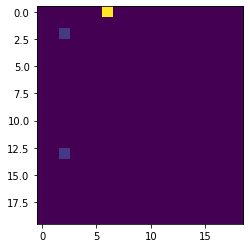

In [0]:
plt.imshow(vectors[:20, 10280:10299])

เปรียบเทียบขนาดเอกสาร กับขนาด matrix จะเห็นว่า row เท่ากัน, column = จำนวน vocab 

In [0]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


ดูจำนวนคำใน vocab ที่เก็บใน vectorizer

In [0]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(26576,)

ดูคำใน vocab

In [0]:
vocab[26000:26020]

array(['wick', 'wickard', 'wicked', 'wide', 'widely', 'widengren',
       'widening', 'wider', 'widespread', 'widget', 'widgets', 'widow',
       'width', 'widths', 'wield', 'wien', 'wiener', 'wierd', 'wierdness',
       'wife'], dtype='<U80')

เปรียบเทียบเอกสารจริง กับ Token Counts

In [0]:
print(newsgroups_train.data[1200])




I sure did use version 3.2. It works fine with most software but NOT
with Animator Pro and that one is quite important to me. Pretty
useless program without that thing working IMHO.
So I hope the author can fix that.

/Daniel...





In [0]:
for i, r in enumerate(reversed(sorted(zip(np.squeeze(np.asarray(vectors[1200, :])), vocab)))):
    print(r)
    if i > 20 : break

(1, 'works')
(1, 'working')
(1, 'version')
(1, 'useless')
(1, 'use')
(1, 'thing')
(1, 'sure')
(1, 'software')
(1, 'quite')
(1, 'program')
(1, 'pro')
(1, 'pretty')
(1, 'important')
(1, 'imho')
(1, 'hope')
(1, 'fix')
(1, 'fine')
(1, 'did')
(1, 'daniel')
(1, 'author')
(1, 'animator')
(0, 'zyxel')


# 4. Latent Semantic Analysis (LSA) 

เมื่อเราได้ Term-Document Matrix ของจำนวนคำศัพท์ที่อยู่ในข้อความทั้งหมดมาแล้ว การนำแต่ละ Vector มาเปรียบเทียบกันตรง ๆ อาจจะไม่ค่อยได้ผล เนื่องจากคำมีหลากหลายมาก ข้อมูลส่วนใหญ่เป็น 0 การเปรียบเทียบ 2 Vector ข้อความที่มีจำนวนคำบางคำใกล้เคียงกัน ไม่สามารถบอกว่าอยู่หมวดหมู่เดียวกันได้

เราจำเป็นต้องนำ Term-Document Matrix ที่ได้มาผ่านกระบวนการ วิเคราะห์หาความหมายที่ซ่อนอยู่ภายใน Latent Semantic Analysis (LSA) ด้วยวิธีการดังนี้

## 4.1 Singular Value Decomposition (SVD)

SVD เป็นวิธี Factorization ยอดนิยม SVD จะแปลง 1 Matrix ขนาดใหญ่ ออกมาเป็น 3 Matrix ขนาดเล็กกว่า ที่คุณกันแล้วได้เท่ากับ Matrix ต้นทาง

3 Matrix ใหม่ที่ได้ออกมา มีคุณสมบัติพิเศษบางอย่าง ทำให้เราสามารถนำมาใช้งาน วิเคราะห์ข้อความได้ดีขึ้น

SVD มีประโยชน์มาก ถูกนำไปประยุกต์ใช้ในหลายงาน เช่น 

* Semantic Analysis
* Collaborative Filtering / Recommendations 
* Calculate Moore-Penrose Pseudoinverse
* Data Compression
* Principal Component Analysis (PCA)

หา svd ของ Matrix ต้นฉบับ ชื่อ vectors ออกมาได้เป็น 3 Matrix ชื่อ U, s Vh

เปรียบเทียบ U คือ รายการ [Embedding](https://www.bualabs.com/archives/996/visualization-embedding-deep-learning-model-deep-neural-networks-tensorboard-ep-2/) ของ Topic by ข้อความ, s คือ Scale ขนาดความสำคัญของ Topic by ข้อความ, Vh คือ รายการ Embedding ของ Vocab by Topic

แทนที่เราจะเปรียบเทียบ 2 ข้อความ ด้วยจำนวนคำศัพท์ในข้อความเหมือนด้านบน ตอนนี้เรามี Abstraction เพิ่มขึ้นมาอีก 1 ตัวคือ Topic ให้เราใช้เปรียบเทียบ ว่า 2 ข้อความมีปริมาณ แต่ละ Topic ใกล้เคียง หรือแตกต่างกันอย่างไร

In [0]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 28s, sys: 4.74 s, total: 1min 33s
Wall time: 47.6 s


ดู shape

In [0]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


ดูตัวอย่างค่า U, s, Vh

In [0]:
U[:10, :10]

array([[-0.00477991,  0.00271988, -0.00121236,  0.00199713, -0.00212815,
         0.00064196,  0.00158918, -0.00616304,  0.00166131, -0.00336103],
       [-0.0002213 , -0.00017499, -0.00107815,  0.00080933, -0.00003156,
         0.0000129 , -0.00038571,  0.0002549 ,  0.0004724 , -0.0005665 ],
       [-0.00063693, -0.00074229, -0.00083183,  0.00133412, -0.00028709,
         0.00076798,  0.00029208,  0.00015722,  0.00019172, -0.0004806 ],
       [-0.00189063, -0.00123553, -0.00390984,  0.00371775, -0.00153613,
         0.00150571,  0.00021251,  0.00054518,  0.00071439,  0.00108918],
       [-0.00035591, -0.00000875, -0.00118536,  0.00054929, -0.00012114,
         0.00019241,  0.00159946,  0.00122869, -0.00028438, -0.00071981],
       [-0.00118922, -0.00028775, -0.0039977 ,  0.00384121, -0.00045495,
         0.00689919, -0.00024674, -0.00190939, -0.00232265,  0.00005183],
       [-0.00124391, -0.00166116, -0.00398698, -0.00182209,  0.00023371,
        -0.00063048,  0.00378086, -0.00005275

In [0]:
Vh[:10, :10]

array([[-0.00940972, -0.0114532 , -0.00002169, -0.00004339, -0.00012376,
        -0.00107793, -0.00005199, -0.00000429, -0.00000576, -0.00002169],
       [-0.00356688, -0.01769167, -0.00003045, -0.0000609 , -0.00029139,
        -0.00185625, -0.00007231, -0.00000497,  0.000003  , -0.00003045],
       [ 0.00094971, -0.02282845, -0.00002339, -0.00004679, -0.00046807,
         0.00151222, -0.00016364, -0.00001991, -0.00000286, -0.00002339],
       [-0.00187147, -0.01143462, -0.00003902, -0.00007804, -0.0005944 ,
         0.00092729, -0.00008254,  0.00001497,  0.00000172, -0.00003902],
       [ 0.00384808,  0.0046023 ,  0.0000232 ,  0.00004639, -0.00044191,
        -0.00264588,  0.00006281,  0.00000353,  0.00000296,  0.0000232 ],
       [-0.00023349, -0.01326198, -0.00000709, -0.00001419,  0.00007106,
        -0.00002707,  0.00001966,  0.00001074,  0.00000115, -0.00000709],
       [ 0.00556666,  0.00991294,  0.00005038,  0.00010075,  0.00105793,
        -0.00078038,  0.00027901,  0.0000081 

s จะเป็น Diagonal Matrix แต่มาในรูป Vector

In [0]:
s[:4]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

 เราต้องแปลงเอง ดังนี้

In [0]:
np.diag(s[:4])

array([[433.92698542,   0.        ,   0.        ,   0.        ],
       [  0.        , 291.51012741,   0.        ,   0.        ],
       [  0.        ,   0.        , 240.71137677,   0.        ],
       [  0.        ,   0.        ,   0.        , 220.00048043]])

แปลงไปแปลงกลับ

In [0]:
np.diag(np.diag(s[:4]))

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

พิสูจน์ว่า U, s Vh มาจาก vectors จริง ๆ ด้วยการ จับคูณกัน

In [0]:
b = np.matmul(U, np.diag(s))
x = np.matmul(b, Vh)

เนื่องจากเป็น เลขทศนิยม ทำให้เราเปรียบเทียบ == กันตรง ๆ ไม่ได้ ต้องใช้ np.isclose()

In [0]:
np.all(np.isclose(x, vectors))

True

U เป็น Orthonormal (orthogonal) Matrix หมายถึง คูณกับตัวเอง Transpose แล้วจะได้ Identity Matrix

In [0]:
x = np.matmul(U, U.T)
x[:10, :10]

array([[ 1., -0.,  0., -0.,  0.,  0., -0.,  0., -0.,  0.],
       [-0.,  1.,  0., -0.,  0.,  0., -0., -0., -0.,  0.],
       [ 0.,  0.,  1., -0.,  0., -0.,  0.,  0.,  0., -0.],
       [-0., -0., -0.,  1., -0.,  0., -0., -0., -0., -0.],
       [ 0.,  0.,  0., -0.,  1.,  0.,  0.,  0.,  0., -0.],
       [ 0.,  0., -0.,  0.,  0.,  1., -0.,  0.,  0.,  0.],
       [-0., -0.,  0., -0.,  0., -0.,  1., -0.,  0., -0.],
       [ 0., -0.,  0., -0.,  0.,  0., -0.,  1., -0.,  0.],
       [-0., -0.,  0., -0.,  0.,  0.,  0., -0.,  1.,  0.],
       [ 0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  1.]])

Vh ก็เป็น Orthonormal (orthogonal) Matrix เหมือนกัน

In [0]:
x = np.matmul(Vh, Vh.T)
x[:10, :10]

array([[ 1., -0., -0., -0.,  0., -0., -0.,  0., -0., -0.],
       [-0.,  1., -0.,  0., -0., -0.,  0., -0.,  0., -0.],
       [-0., -0.,  1., -0., -0., -0., -0.,  0., -0., -0.],
       [-0.,  0., -0.,  1., -0.,  0.,  0., -0.,  0., -0.],
       [ 0., -0., -0., -0.,  1.,  0.,  0., -0.,  0.,  0.],
       [-0., -0., -0.,  0.,  0.,  1.,  0., -0., -0.,  0.],
       [-0.,  0., -0.,  0.,  0.,  0.,  1., -0., -0.,  0.],
       [ 0., -0.,  0., -0., -0., -0., -0.,  1.,  0., -0.],
       [-0.,  0., -0.,  0.,  0., -0., -0.,  0.,  1.,  0.],
       [-0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,  1.]])

s คือ Scale Matrix บอกถึงขนาดความสำคัญของ Topic by ข้อความ เมื่อนำมาพล็อตกราฟ จะได้ดังนี้

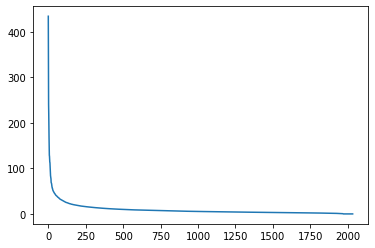

In [0]:
plt.plot(s);

ซูมเข้าไปดู 10 มิติแรก จะเห็นว่าข้อมูลส่วนใหญ่อยู่ Topic แรก ๆ เท่านั้น

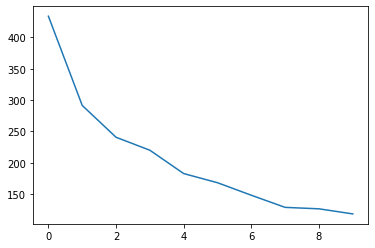

In [0]:
plt.plot(s[:10])

ประกาศฟังก์ชัน แสดงคำศัพท์ใน vocab ที่พบมากที่สุด 8 คำ ในแต่ละ Topic ใน Vh

In [0]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

แสดงคำศัพท์ใน vocab ที่พบมากที่สุด 8 คำ ใน 10 Topic แรก เมื่อดูรายการคำศัพท์ ทำให้เราพอจะเดาได้ว่า ถ้าเอกสารมี Topic นี้มาก น่าจะถูกจำแนกอยู่ใน Category อะไร

In [0]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

นำ 3 มิติแรก มาพล็อตกราฟ

In [0]:
dataset = pd.DataFrame({'Column1': U[:, 0], 'Column2': U[:, 1], 
                        'Column3': U[:, 2], 'Category': newsgroups_train.target})

iris = px.data.iris()
fig = px.scatter_3d(dataset, x='Column1', y='Column2', z='Column3', 
                    color='Category')
fig.show()

## 4.2 Non-negative Matrix Factorization (NMF)

แต่ SVD ก็มีปัญหาคือ มีค่าเป็นติดลบได้ ทำให้มีปัญหาต่อการตีความ จึงมี Matrix Factorization อีกหนึ่งวิธีที่เป็นที่นิยม คือ Non-negative Matrix Factorization (NMF) มาแก้ปัญหาค่าติดลบ ตามชื่อ คือ ผลลัพท์จะได้ Matrix ที่เป็นค่าบวกเท่านั้น 

แต่มีข้อเสียคือ เป็นค่าประมาณ ทำให้ไม่สามารถรวมกลับเป็น Matrix ต้นฉบับเหมือนเดิมได้เหมือน SVD และ เป็น NMF อัลกอริทึม เป็น nondeterministic คือทำงานแต่ละครั้ง ผลลัพธ์อาจจะไม่เท่ากันก็ได้

ข้อดีของค่าประมาณ คือ จัดการกับ Missing Value ได้ดีกว่า

In [0]:
m,n=vectors.shape

เราจะ Decompose vectors ออกเป็น 5 Topic

In [0]:
d=5  # num topics

clf = decomposition.NMF(n_components=d, random_state=1)
W1 = clf.fit_transform(vectors)
H1 = clf.components_

W1.shape, H1.shape

((2034, 5), (5, 26576))

จะเห็นว่า จำนวนคำศัพท์บางคำ ใน Topic แรก มีค่าโดดมาก

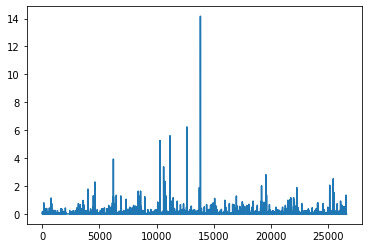

In [0]:
plt.plot(clf.components_[0])

In [0]:
W1[:10]

array([[0.08858936, 0.02984714, 0.        , 0.04220515, 0.        ],
       [0.        , 0.00074146, 0.0037713 , 0.02133068, 0.00096886],
       [0.        , 0.01650813, 0.00026615, 0.02582674, 0.00294897],
       [0.00614964, 0.03209064, 0.01430699, 0.08909122, 0.        ],
       [0.00340253, 0.        , 0.0074062 , 0.01922605, 0.        ],
       [0.00637911, 0.00703127, 0.00727478, 0.08983142, 0.00081548],
       [0.        , 0.        , 0.06515014, 0.02315396, 0.02111438],
       [0.02420288, 0.01125148, 0.00629759, 0.06641558, 0.02957365],
       [0.        , 0.        , 0.05084285, 0.02340395, 0.        ],
       [0.00089451, 0.01613498, 0.        , 0.00430944, 0.10811108]])

In [0]:
H1[:, :10]

array([[0.12126083, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00013644, 0.        ],
       [0.11928575, 0.12085267, 0.00016592, 0.00033183, 0.001661  ,
        0.05162843, 0.        , 0.00001486, 0.00001065, 0.00016592],
       [0.05766391, 0.48160644, 0.0007993 , 0.00159861, 0.01428189,
        0.        , 0.00304175, 0.0000783 , 0.00000395, 0.0007993 ],
       [0.        , 0.14794335, 0.        , 0.        , 0.        ,
        0.        , 0.00080554, 0.00036579, 0.00005702, 0.        ],
       [0.12742192, 0.19356417, 0.00050472, 0.00100944, 0.        ,
        0.        , 0.00115775, 0.00006883, 0.0000649 , 0.00050472]])

In [0]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

นำ 3 มิติแรก มาพล็อตกราฟ

In [0]:
dataset = pd.DataFrame({'Column1': W1[:, 0], 'Column2': W1[:, 1], 
                        'Column3': W1[:, 2], 'Category': newsgroups_train.target})

iris = px.data.iris()
fig = px.scatter_3d(dataset, x='Column1', y='Column2', z='Column3', 
                    color='Category')
fig.show()

# 5. Term Frequency–Inverse Document Frequency (TF-IDF)

การใช้ Count Vectorizer สร้าง Term-Document Matrix จะมีปัญหา ถ้าแต่ละข้อความใน Dataset ของเรา มีความยาวต่างกันมาก ๆ การนับจำนวนคำที่อยู่ในข้อความ มาเปรียบเทียบกันก็อาจจะไม่แฟร์ได้ 

TF-IDF เข้ามาแก้ปัญหานี้ โดยการนำจำนวนคำทั้งหมดที่อยู่ภายในเอกสารมาหาร แปลงให้เป็นสัดส่วน แทนที่จะใช้จำนวนนับตรง ๆ เหมือนด้านบน

In [0]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

vectors_tfidf.shape

(2034, 26576)

จะเห็นว่าเป็นเลขทศนิยม (สัดส่วน) ไม่ใช่จำนวนนับ (จำนวนครั้งที่คำศัพท์ปรากฎในข้อความ)

In [0]:
vectors_tfidf[:10, 10280:10299].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.44662488, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.11742128, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        

In [0]:
print("\n============================\n".join(newsgroups_train.data[1200:1203]))




I sure did use version 3.2. It works fine with most software but NOT
with Animator Pro and that one is quite important to me. Pretty
useless program without that thing working IMHO.
So I hope the author can fix that.

/Daniel...



 
 
It was no criticism of Islam for a change, it was a criticism of the
arguments used. Namely, whenever people you identify as Muslims are
the victims of the attacks of others, they are used an argument for
the bad situation of Muslims. But whenever deeds by Muslim that victimize
others are named, they do not count as an argument because what these
people did was not done as a true Muslims. No mention is made how Muslims
are the cause of a bad situation of another party.


Hmmmm....  The prefix "peri-" is Greek, not Latin, so it's usually used
with the Greek form of the name of the body being orbited.  (That's why
it's "perihelion" rather than "perisol", "perigee" rather than "periterr",
and "pericynthion" rather than "perilune".)  So for Jupiter I'd ex

In [0]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

W1.shape, H1.shape

((2034, 5), (5, 26576))

จะทำให้ vocab ใน Topic กระจายตัว แฟร์มากขึ้น เทียบกับ Count ด้านบน

In [0]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

Embedding Vocab by Topic มิติแรก ค่อนข้างกระจายดี

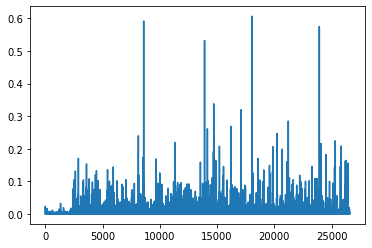

In [0]:
plt.plot(clf.components_[0])

เราไม่สามารถรวมเป็น Matrix ต้นฉบับเหมือนเดิมเป๊ะได้ จะมี Error

In [0]:
clf.reconstruction_err_

43.712926057952785

# 6. Truncated SVD

ปัญหาอีกอย่างนึงของ SVD คือ ทำงานช้า มีการพัฒนาอัลกอริทึม ชื่อว่า Randomized SVD และ Truncated SVD ช่วยให้ทำงานเร็วขึ้น หลายสิบเท่า

In [0]:
%time u, s, v = np.linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 26s, sys: 4.85 s, total: 1min 31s
Wall time: 47 s


In [0]:
from sklearn import decomposition
import fbpca

In [0]:
%time u, s, v = decomposition.randomized_svd(vectors, 10)

CPU times: user 7.68 s, sys: 2.04 s, total: 9.72 s
Wall time: 5.04 s


In [0]:
%time u, s, v = fbpca.pca(vectors, 10)

CPU times: user 2.59 s, sys: 861 ms, total: 3.45 s
Wall time: 1.84 s


# Credit

* https://github.com/fastai/course-nlp
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
* https://research.fb.com/fast-randomized-svd/
* https://plot.ly/python/3d-scatter-plots/